 **Part 2:**
  - **Task 3:** Create a fraud detection model capable of detecting fraudulent transactions. The dataset `transactions_data.csv` will be split for training and prediction. Predictions should only be made for the transaction IDs listed in `predictions/predictions_3.json`. The fraud labels for training can be found at:
    - [Download transaction fraud labels](https://cdn.nuwe.io/challenges-ds-datasets/hackathon-caixabank-data-24/train_fraud_labels.json)
  - **Task 4:** Develop a forecast model to predict monthly **expenses** (negative amounts) for each client in `predictions/predictions_4.json`. Forecast the monthly expenses for the next three months based on each client's most recent transaction date. The output format can be found in the `predictions/predictions_4.json` file.

### LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import preprocessing


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

### IMPORTING FILES

In [3]:
transaction_data = pd.read_csv("https://cdn.nuwe.io/challenges-ds-datasets/hackathon-caixabank-data-24/transactions_data.csv")
fraud_labels = pd.read_json("https://cdn.nuwe.io/challenges-ds-datasets/hackathon-caixabank-data-24/train_fraud_labels.json").reset_index().rename(columns= {"index":"transaction_id"})
projections_3 = pd.read_json("/Users/adolfoartolamadrigal/Documents/Irohacks/Hackaton/hackathon-caixabank-data-ai-report/predictions/predictions_3.json").reset_index().rename(columns={"index":"transaction_id"})
client_data = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Hackaton/users_data.csv")
cards_data = pd.read_csv("/Users/adolfoartolamadrigal/Documents/Irohacks/Hackaton/cards_data.csv")

### DATA CLEANING

In [4]:
cols = [col for col in transaction_data.columns.values.tolist()]
nulls_df = pd.DataFrame({"cols" : cols,"null": [transaction_data[col].isna().sum() for col in cols ]})

nulls_df

,cols,null
0,id,0
1,date,0
2,client_id,0
3,card_id,0
4,amount,0
5,use_chip,0
6,merchant_id,0
7,merchant_city,0
8,merchant_state,1563700
9,zip,1652706


In [5]:
transaction_data.drop(columns="errors",inplace=True)
transaction_data["merchant_country"] = transaction_data["merchant_state"].apply(
    lambda x: "United States of America" if isinstance(x, str) and len(x) == 2 else x)

transaction_data.loc[transaction_data["merchant_state"].isna(),"merchant_state"] = "ONLINE"
transaction_data.loc[transaction_data["merchant_country"].isna(),"merchant_country"] = "ONLINE"
transaction_data["city_state_country"] = transaction_data["merchant_city"] + "_" + transaction_data["merchant_state"] + "_" +transaction_data["merchant_country"]
transaction_data.loc[transaction_data["merchant_state"]=="ONLINE","zip"] = 00000.1
transaction_data.loc[transaction_data["zip"].isna(),"zip"] = 10000.1
regex_pattern = r'^\$'
transaction_data["amount"] = pd.to_numeric(transaction_data["amount"].str.replace(regex_pattern,"",regex=True))
transaction_data["date"] = pd.to_datetime(transaction_data["date"])


In [6]:
zip_pivot_table = pd.pivot_table(data =transaction_data, index=["city_state_country","zip"],values="merchant_country",aggfunc="count").reset_index()

### EDA

In [7]:
# year = transaction_data["date"].dt.year
# px.histogram(transaction_data,x = year,y = "amount", histfunc="sum",title="Total Transactions per year")

In [8]:
numercial_columns = transaction_data.select_dtypes(include=np.number)
categorical_columns = transaction_data.select_dtypes(include = "object")
date_columns = transaction_data.select_dtypes(include = "datetime")

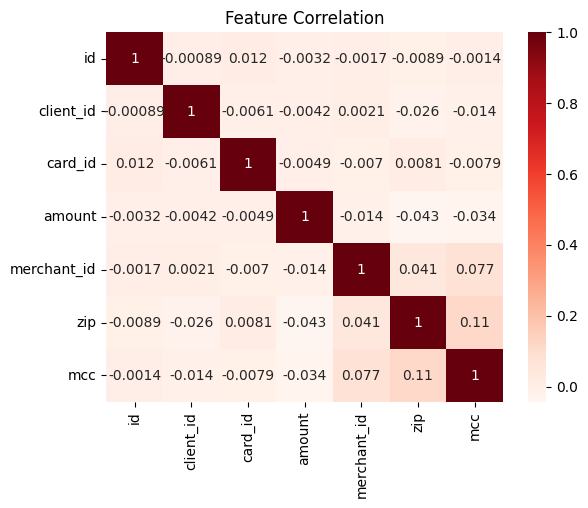

In [22]:
plt.title("Feature Correlation")
sns.heatmap(numercial_columns.corr(),cmap="Reds",annot=True)
plt.show()

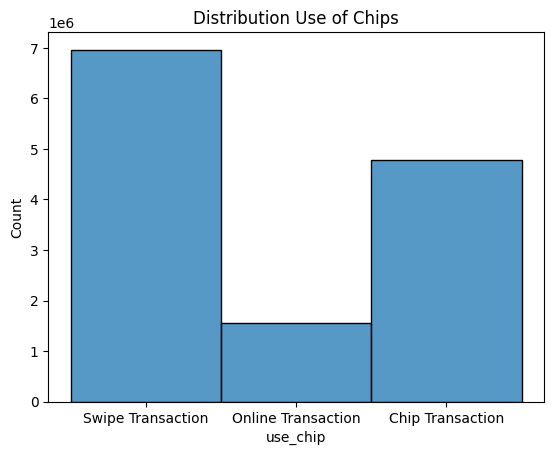

In [10]:
sns.histplot(categorical_columns,x="use_chip",stat="count")
plt.title("Distribution Use of Chips")
plt.show()

### MACHINE LEARNING PROJECT

#### Libraries

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### Split the Data

In [12]:
train_df = transaction_data.merge(fraud_labels,how="inner", left_on="id", right_on="transaction_id")
target_codes = {"No":0,"Yes":1}
train_df["target"] = train_df["target"].map(target_codes)
train_df["hour"] = train_df["date"].dt.hour
train_df.drop(columns=["transaction_id","date","city_state_country"], inplace = True)


test_df = transaction_data.loc[transaction_data["id"].isin(projections_3["transaction_id"].values.tolist())]
test_df["hour"] = test_df["date"].dt.hour
test_df.drop(columns=["date","city_state_country"], inplace = True)

/var/folders/6g/dhv5ylld76zgp_63c85rplcc0000gn/T/ipykernel_1462/2615124676.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["hour"] = test_df["date"].dt.hour
/var/folders/6g/dhv5ylld76zgp_63c85rplcc0000gn/T/ipykernel_1462/2615124676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["date","city_state_country"], inplace = True)


#### Encoding Categorical Variables

In [13]:
categorical_columns = train_df.select_dtypes(include="object").columns.to_list()
pd.DataFrame(
    {"col": [col for col in categorical_columns],
     "count":[train_df[col].nunique()for col in categorical_columns]}
)

,col,count
0,use_chip,3
1,merchant_city,12173
2,merchant_state,200
3,merchant_country,149


##### One hot encoding

In [14]:
encoder = OneHotEncoder(sparse_output=False) 
train_use_chip_encoded = encoder.fit_transform(train_df[['use_chip']])
test_use_chip_encoded = encoder.transform(test_df[['use_chip']])

train_use_chip_df = pd.DataFrame(train_use_chip_encoded, columns=encoder.get_feature_names_out(['use_chip']))
test_use_chip_df = pd.DataFrame(test_use_chip_encoded, columns=encoder.get_feature_names_out(['use_chip']))



##### Label_Encoding

In [15]:
train_df = train_df.copy()
test_df = test_df.copy()

high_cardinality_cols = ['merchant_city']
label_encoders = {}

for col in high_cardinality_cols:
  
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))  # Fit on training data
    
 
    value_map = {label: idx for idx, label in enumerate(le.classes_)}
    default_value = -1  # Assign -1 to unseen labels
    
 
    train_df.loc[:, f"{col}_encoded"] = train_df[col].astype(str).map(value_map)
    test_df.loc[:, f"{col}_encoded"] = test_df[col].astype(str).map(value_map).fillna(default_value).astype(int)
    
    
    label_encoders[col] = le

    train_df = train_df.copy()
test_df = test_df.copy()

high_cardinality_cols = ['merchant_state']
label_encoders = {}

for col in high_cardinality_cols:
  
    le = LabelEncoder()
    le.fit(train_df[col].astype(str)) 
    
   
    value_map = {label: idx for idx, label in enumerate(le.classes_)}
    default_value = -1 
    

    train_df.loc[:, f"{col}_encoded"] = train_df[col].astype(str).map(value_map)
    test_df.loc[:, f"{col}_encoded"] = test_df[col].astype(str).map(value_map).fillna(default_value).astype(int)
    
    label_encoders[col] = le


train_df = train_df.copy()
test_df = test_df.copy()

high_cardinality_cols = ['merchant_country']
label_encoders = {}

for col in high_cardinality_cols:
    # Fit LabelEncoder
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))  # Fit on training data
    
    # Create mapping dictionary
    value_map = {label: idx for idx, label in enumerate(le.classes_)}
    default_value = -1  # Assign -1 to unseen labels
    
    # Create a new column with encoded values in both train and test datasets
    train_df.loc[:, f"{col}_encoded"] = train_df[col].astype(str).map(value_map)
    test_df.loc[:, f"{col}_encoded"] = test_df[col].astype(str).map(value_map).fillna(default_value).astype(int)
    
    # Store the encoder for reference
    label_encoders[col] = le


In [16]:
train_df = train_df.select_dtypes(include= np.number)
test_df = test_df.select_dtypes(include=np.number)

train_df = pd.concat([train_df.reset_index(drop=True), train_use_chip_df.reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_use_chip_df.reset_index(drop=True)], axis=1)

### XGBoost

In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report


In [18]:
y = train_df["target"]
X = train_df.drop(columns = ["id","target"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,)

model = XGBClassifier(max_depth=8, learning_rate=0.05, n_estimators=200, random_state=42,subsample=0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [ ]:
model2 = XGBClassifier(random_state=42)

param_grid = {
    "max_depth": [6, 10],            # Controls the depth of the trees
    "learning_rate": [0.01, 0.1], # Step size shrinkage to prevent overfitting
    "n_estimators": [100, 300],    # Number of trees in the model
    "subsample": [0.9, 1.0],       # Fraction of samples used for training
    "colsample_bytree": [0.9, 1.0], # Fraction of features used for training
    "scale_pos_weight": [10, 20]     # Balancing classes (for imbalanced data)
}

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring="f1",
    cv=3,         
    verbose=2,    
    n_jobs=-1    
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

print(classification_report(y_val, y_pred))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time= 3.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time= 3.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=10, subsample=0.9; total time= 3.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=10, subsample=1.0; total time= 3.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=20, subsample=0.9; total time= 3.6min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=10, subsample=0.9; total time= 3.6min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, n_estimators=100, scale_pos_weight=20, subsample=0.9

### EVALUATING MODEL

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1780277      80]
 [    635    2001]]


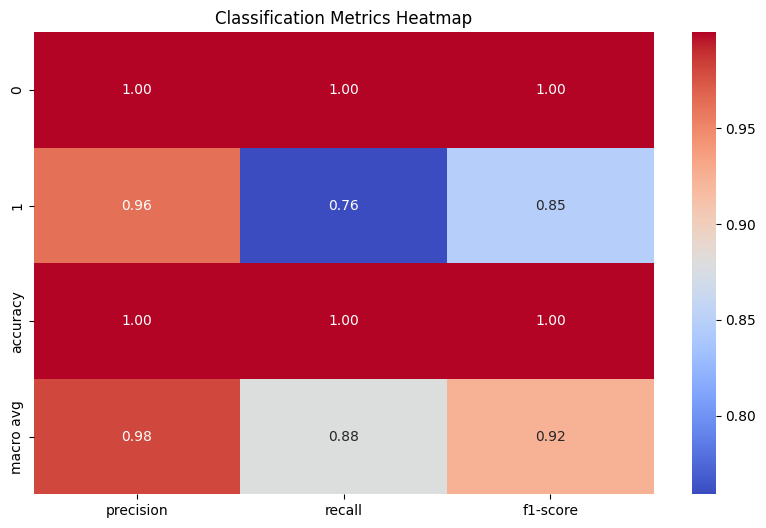

Precision: 96% of the instances that the model predicted as fraudulent were actually fraudulent
Recall: 76% of the actual positive instances (fraudulent transactions) were correctly identified by the model
F1: The F1-score is the harmonic mean of precision and recall
The accuracy is 1.00, meaning that 100% of the predictions are correct (this is likely due to the large imbalance in the dataset


In [20]:
report_dict = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Classification Metrics Heatmap")
plt.show()


print("Precision: 96% of the instances that the model predicted as fraudulent were actually fraudulent")
print("Recall: 76% of the actual positive instances (fraudulent transactions) were correctly identified by the model")
print("F1: The F1-score is the harmonic mean of precision and recall")
print("The accuracy is 1.00, meaning that 100% of the predictions are correct (this is likely due to the large imbalance in the dataset")



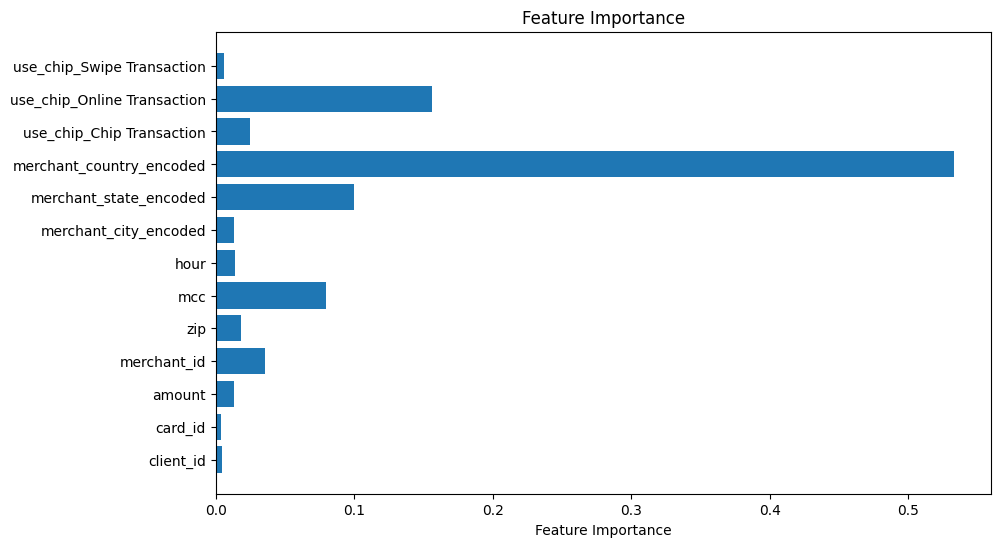

In [60]:
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

In [72]:
X_new = [[12345, 67890, 100.50, 123, 54321,6000, 20, 101, 1, 2, 3, 4, 5]]

In [73]:
prediction = model.predict(X_new)